In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy

Training GAN

In [2]:
def build_generator(latent_dim, img_shape,complexity):
    model = models.Sequential()
    model.add(layers.Dense(complexity, input_dim=latent_dim))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Dense(2*complexity))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Dense(3*complexity))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Dense(np.prod(img_shape), activation='tanh'))
    model.add(layers.Reshape(img_shape))
    return model

def build_discriminator(img_shape, complexity):
    model = models.Sequential()
    model.add(layers.Flatten(input_shape=img_shape))
    model.add(layers.Dense(3*complexity))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dense(2*complexity))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5), metrics=['accuracy'])
    return model

def build_gan(generator, discriminator):
    discriminator.trainable = False
    model = models.Sequential()
    model.add(generator)
    model.add(discriminator)
    model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5), metrics=['accuracy'])
    return model

Calculating JSD

In [3]:
def jsd(prob_real, prob_fake):
    """
    Calculate Jensen-Shannon Divergence.
    """
    prob_real = np.clip(prob_real, 1e-10, 1.0)
    prob_fake = np.clip(prob_fake, 1e-10, 1.0)
    m = 0.5 * (prob_real + prob_fake)
    return 0.5 * (entropy(prob_real, m) + entropy(prob_fake, m))

Functions to plot original and constructed images

In [4]:
def plot_original_and_generated_images(generator, epoch, latent_dim, examples=10, dim=(2, 10), figsize=(15, 3)):
    noise = np.random.normal(0, 1, size=[examples, latent_dim])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(examples, 32, 32, 3)

    # Load original images
    (X_train, _), (_, _) = tf.keras.datasets.cifar10.load_data()
    original_images = X_train[np.random.randint(0, X_train.shape[0], size=examples)]

    plt.figure(figsize=figsize)
    for i in range(examples):
        # Plot original image with title
        plt.subplot(dim[0], dim[1], i * 2 + 1)
        plt.imshow(original_images[i])
        plt.title("Original Image", fontsize=8)
        plt.axis('off')

        # Plot generated image with title
        plt.subplot(dim[0], dim[1], i * 2 + 2)
        plt.imshow((generated_images[i] + 1) / 2, interpolation='nearest')  # Scale back to [0, 1]
        plt.title("Generated Image", fontsize=8)
        plt.axis('off')

    plt.tight_layout()
    plt.savefig(f'gan_generated_image_epoch_{epoch}.png')

Function to plot JSD

In [5]:
def plot_jsd_over_epochs(jsd_values):
    """
    Plot Jenson-Shannon Divergence over epochs.
    """
    plt.figure()
    plt.plot(jsd_values)
    plt.title('Jenson-Shannon Divergence over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('JSD Value')
    plt.show()

Training a GAN Model

In [6]:
def train_gan(generator, discriminator, gan, epochs, batch_size):
    (X_train, _), (_, _) = tf.keras.datasets.cifar10.load_data()
    X_train = (X_train.astype(np.float32) - 127.5) / 127.5
    #X_train = np.expand_dims(X_train, axis=-1)  # Add channel dimension for grayscale images
    jsd_values = []

    for epoch in range(epochs):
        for _ in range(X_train.shape[0] // batch_size):
            noise = np.random.normal(0, 1, size=[batch_size, latent_dim])
            generated_images = generator.predict(noise)
            image_batch = X_train[np.random.randint(0, X_train.shape[0], size=batch_size)]

            X = np.concatenate([image_batch, generated_images])
            y_dis = np.zeros(2 * batch_size)
            y_dis[:batch_size] = 0.9

            discriminator.trainable = True
            d_loss = discriminator.train_on_batch(X, y_dis)

            noise = np.random.normal(0, 1, size=[batch_size, latent_dim])
            y_gen = np.ones(batch_size)
            discriminator.trainable = False
            g_loss = gan.train_on_batch(noise, y_gen)

        # Calculate JSD
        noise_real = np.random.normal(0, 1, size=[batch_size, latent_dim])
        generated_images_real = generator.predict(noise_real)
        prob_real = discriminator.predict(image_batch)  # Corrected probability calculation

        noise_fake = np.random.normal(0, 1, size=[batch_size, latent_dim])
        generated_images_fake = generator.predict(noise_fake)
        prob_fake = discriminator.predict(generated_images_fake)  # Corrected probability calculation

        jsd_value = jsd(prob_real, prob_fake)
        jsd_values.append(jsd_value)

        print(f"Epoch {epoch + 1}/{epochs} [D loss: {d_loss[0]}] [G loss: {g_loss[0]}] [JSD: {jsd_value}]")



    return generator, jsd_values

Setting up general parameter

In [7]:
epochs = 5
batch_size = 128

Behaviour of latent dimensionality values

With latent_dim=5 and complexity=128


4/4 [==============================] - 0s 4ms/step
Epoch 1/5 [D loss: 0.6629326343536377] [G loss: 1.381864309310913] [JSD: [0.0212275]]
4/4 [==============================] - 0s 4ms/step
Epoch 2/5 [D loss: 0.7069517374038696] [G loss: 1.2476762533187866] [JSD: [0.02233856]]
4/4 [==============================] - 0s 4ms/step
Epoch 3/5 [D loss: 0.7132781147956848] [G loss: 1.1837495565414429] [JSD: [0.03127849]]
4/4 [==============================] - 0s 5ms/step
Epoch 4/5 [D loss: 0.6623179912567139] [G loss: 1.0860860347747803] [JSD: [0.02167286]]
4/4 [==============================] - 0s 4ms/step
Epoch 5/5 [D loss: 0.6796348094940186] [G loss: 0.9499759078025818] [JSD: [0.01642673]]
1/1 [==============================] - 0s 135ms/step


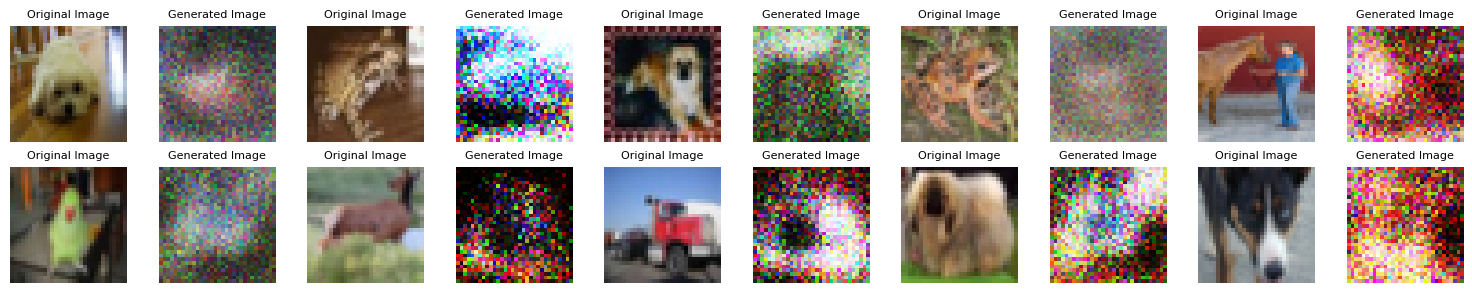

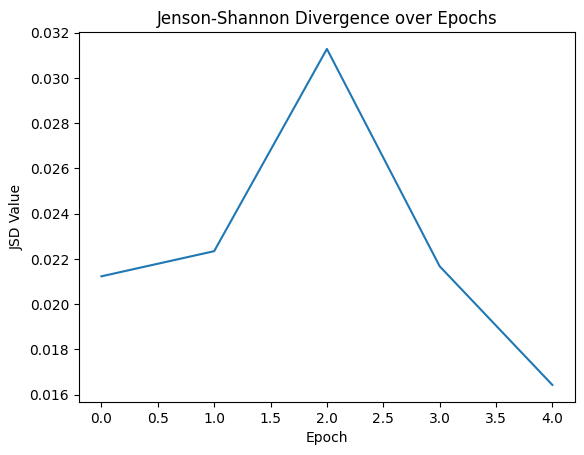

With latent_dim=10 and complexity=128


4/4 [==============================] - 0s 4ms/step
Epoch 1/5 [D loss: 0.4474885165691376] [G loss: 3.784072160720825] [JSD: [0.0780038]]
4/4 [==============================] - 0s 4ms/step
Epoch 2/5 [D loss: 0.434821754693985] [G loss: 1.930369257926941] [JSD: [0.09007499]]
4/4 [==============================] - 0s 4ms/step
Epoch 3/5 [D loss: 0.3502175211906433] [G loss: 3.235635280609131] [JSD: [0.18633679]]
4/4 [==============================] - 0s 5ms/step
Epoch 4/5 [D loss: 0.3671668767929077] [G loss: 2.438155174255371] [JSD: [0.11434049]]
4/4 [==============================] - 0s 4ms/step
Epoch 5/5 [D loss: 0.33751124143600464] [G loss: 2.793821096420288] [JSD: [0.09412148]]
1/1 [==============================] - 0s 193ms/step


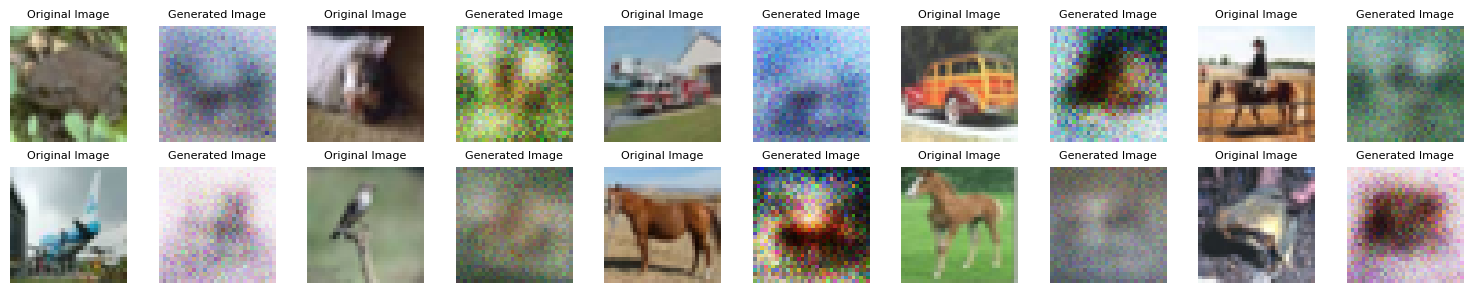

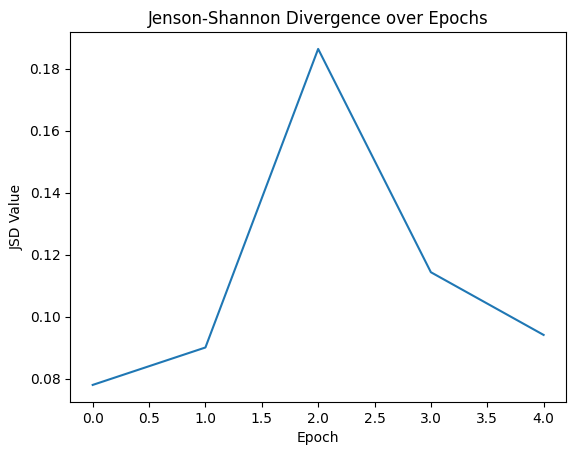

With latent_dim=50 and complexity=128


4/4 [==============================] - 0s 4ms/step
Epoch 1/5 [D loss: 0.6662570238113403] [G loss: 0.9271892309188843] [JSD: [0.03151865]]
4/4 [==============================] - 0s 4ms/step
Epoch 2/5 [D loss: 0.7230454087257385] [G loss: 0.7890857458114624] [JSD: [0.00727043]]
4/4 [==============================] - 0s 5ms/step
Epoch 3/5 [D loss: 0.7004373073577881] [G loss: 0.8137415647506714] [JSD: [0.00839993]]
4/4 [==============================] - 0s 5ms/step
Epoch 4/5 [D loss: 0.7035447359085083] [G loss: 0.8465673923492432] [JSD: [0.00344805]]
4/4 [==============================] - 0s 4ms/step
Epoch 5/5 [D loss: 0.6941277980804443] [G loss: 0.830303430557251] [JSD: [0.0030062]]
1/1 [==============================] - 0s 131ms/step


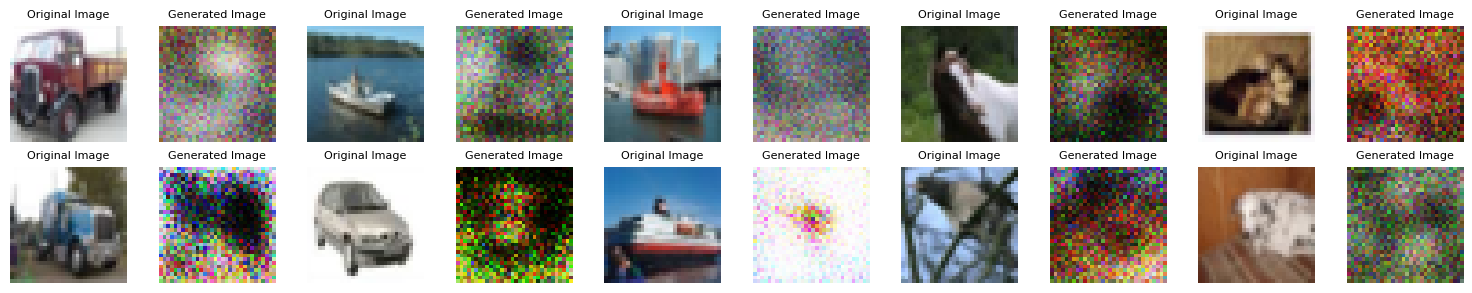

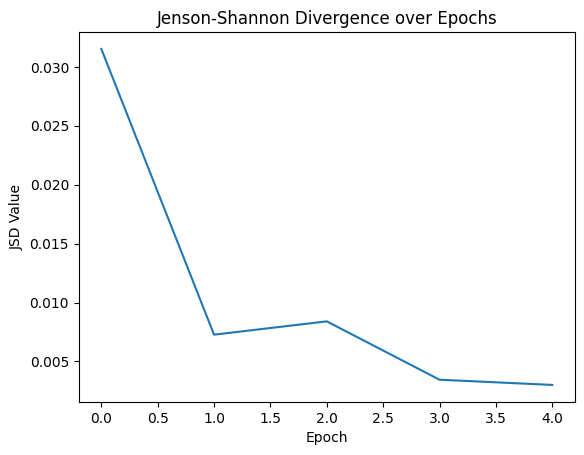

With latent_dim=100 and complexity=128


4/4 [==============================] - 0s 4ms/step
Epoch 1/5 [D loss: 0.7234187126159668] [G loss: 1.2087175846099854] [JSD: [0.02968991]]
4/4 [==============================] - 0s 5ms/step
Epoch 2/5 [D loss: 0.6797313690185547] [G loss: 0.8348598480224609] [JSD: [0.00439426]]
4/4 [==============================] - 0s 6ms/step
Epoch 3/5 [D loss: 0.6816431879997253] [G loss: 0.7900311350822449] [JSD: [0.00359932]]
4/4 [==============================] - 0s 4ms/step
Epoch 4/5 [D loss: 0.6842089891433716] [G loss: 0.8597975969314575] [JSD: [0.00251509]]
4/4 [==============================] - 0s 5ms/step
Epoch 5/5 [D loss: 0.6851553320884705] [G loss: 0.7801167368888855] [JSD: [0.00256948]]
1/1 [==============================] - 0s 136ms/step


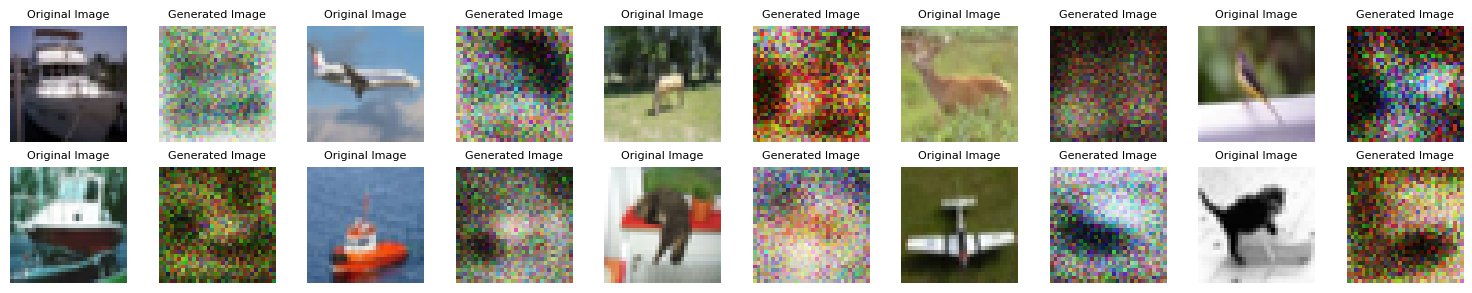

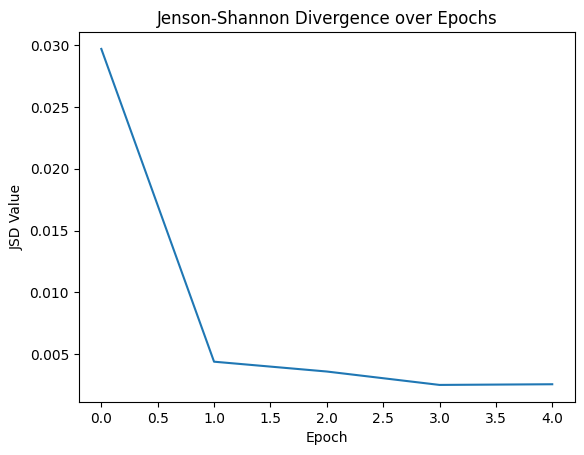

In [8]:
latent_dim_values = [5, 10, 50, 100]
complexity = 128

# Set the image shape for CIFAR-10
img_shape = (32, 32, 3)

for latent_dim in latent_dim_values:
      print(f"With latent_dim={latent_dim} and complexity={complexity}")
      # Build the generator, discriminator, and GAN
      generator = build_generator(latent_dim, img_shape,complexity)
      discriminator = build_discriminator(img_shape,complexity)
      gan = build_gan(generator, discriminator)
      generator, jsd_values = train_gan(generator, discriminator, gan, epochs, batch_size)
      plot_original_and_generated_images(generator, epochs, latent_dim)
      plot_jsd_over_epochs(jsd_values)

With latent_dim=100 and complexity=32


4/4 [==============================] - 0s 3ms/step
Epoch 1/5 [D loss: 0.8152169585227966] [G loss: 1.5211913585662842] [JSD: [0.06895692]]
4/4 [==============================] - 0s 3ms/step
Epoch 2/5 [D loss: 0.6787071228027344] [G loss: 0.9466666579246521] [JSD: [0.01196897]]
4/4 [==============================] - 0s 3ms/step
Epoch 3/5 [D loss: 0.6919498443603516] [G loss: 0.8781980276107788] [JSD: [0.01045813]]
4/4 [==============================] - 0s 3ms/step
Epoch 4/5 [D loss: 0.7157098650932312] [G loss: 0.9029804468154907] [JSD: [0.00682727]]
4/4 [==============================] - 0s 3ms/step
Epoch 5/5 [D loss: 0.6836664080619812] [G loss: 0.8471715450286865] [JSD: [0.0057553]]
1/1 [==============================] - 0s 125ms/step


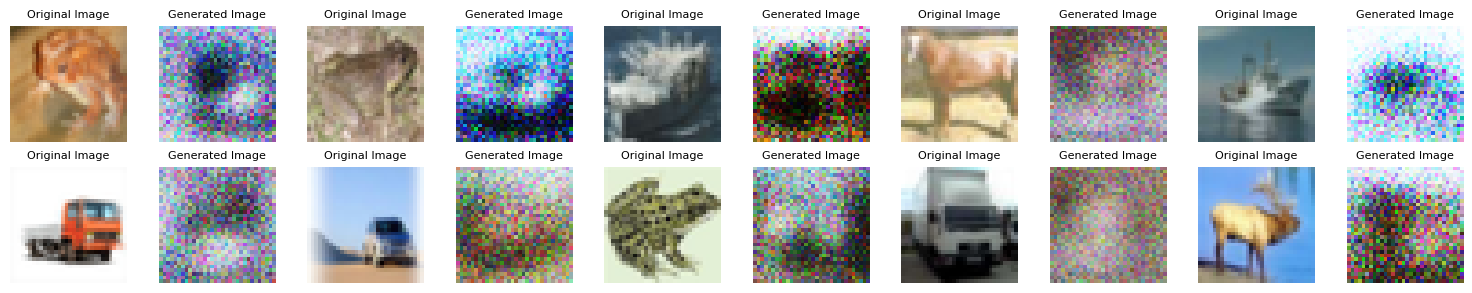

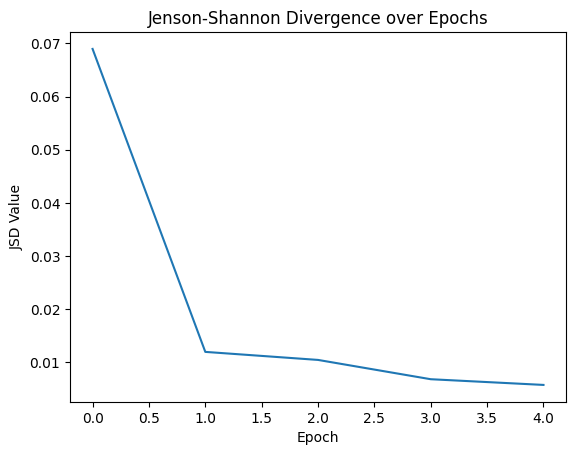

With latent_dim=100 and complexity=64


4/4 [==============================] - 0s 3ms/step
Epoch 1/5 [D loss: 0.7969735860824585] [G loss: 1.2370094060897827] [JSD: [0.03393857]]
4/4 [==============================] - 0s 4ms/step
Epoch 2/5 [D loss: 0.7168095111846924] [G loss: 0.9696794748306274] [JSD: [0.03020967]]
4/4 [==============================] - 0s 4ms/step
Epoch 3/5 [D loss: 0.6901675462722778] [G loss: 0.8871066570281982] [JSD: [0.00739836]]
4/4 [==============================] - 0s 4ms/step
Epoch 4/5 [D loss: 0.7076286673545837] [G loss: 0.9548397660255432] [JSD: [0.00599579]]
4/4 [==============================] - 0s 5ms/step
Epoch 5/5 [D loss: 0.6746765375137329] [G loss: 0.8766047954559326] [JSD: [0.00340921]]
1/1 [==============================] - 0s 153ms/step


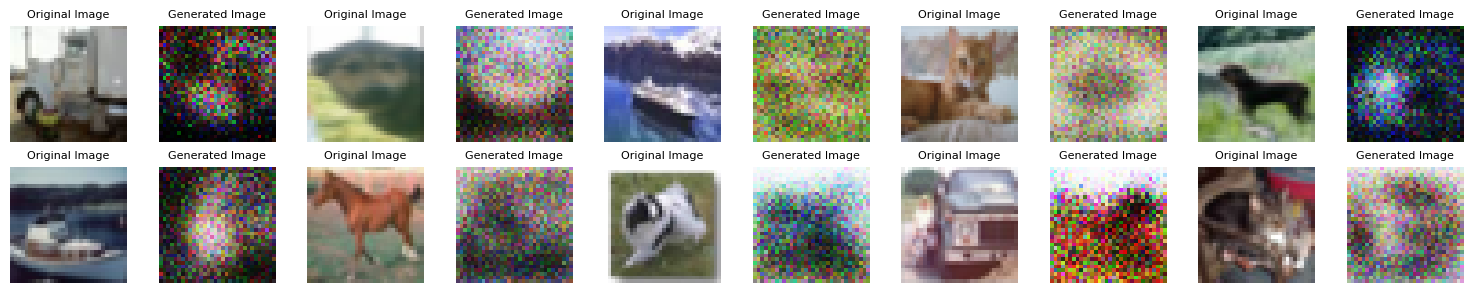

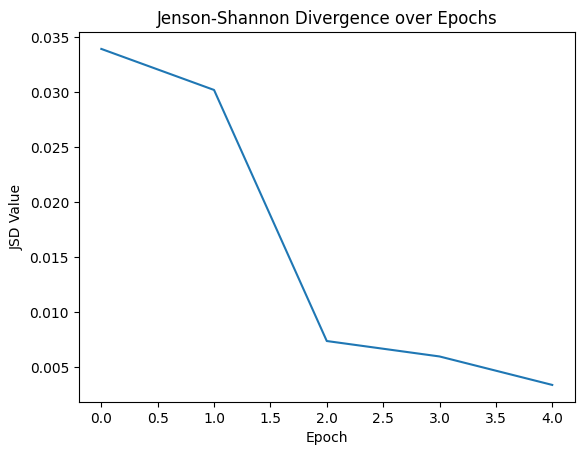

With latent_dim=100 and complexity=128


4/4 [==============================] - 0s 5ms/step
Epoch 1/5 [D loss: 0.6955162882804871] [G loss: 1.081369161605835] [JSD: [0.01465618]]
4/4 [==============================] - 0s 4ms/step
Epoch 2/5 [D loss: 0.6938228607177734] [G loss: 0.8653799891471863] [JSD: [0.01187653]]
4/4 [==============================] - 0s 6ms/step
Epoch 3/5 [D loss: 0.7046618461608887] [G loss: 0.8288226127624512] [JSD: [0.00496106]]
4/4 [==============================] - 0s 5ms/step
Epoch 4/5 [D loss: 0.6911133527755737] [G loss: 0.842674970626831] [JSD: [0.00289483]]
4/4 [==============================] - 0s 5ms/step
Epoch 5/5 [D loss: 0.6850825548171997] [G loss: 0.8119311332702637] [JSD: [0.0024344]]
1/1 [==============================] - 0s 153ms/step


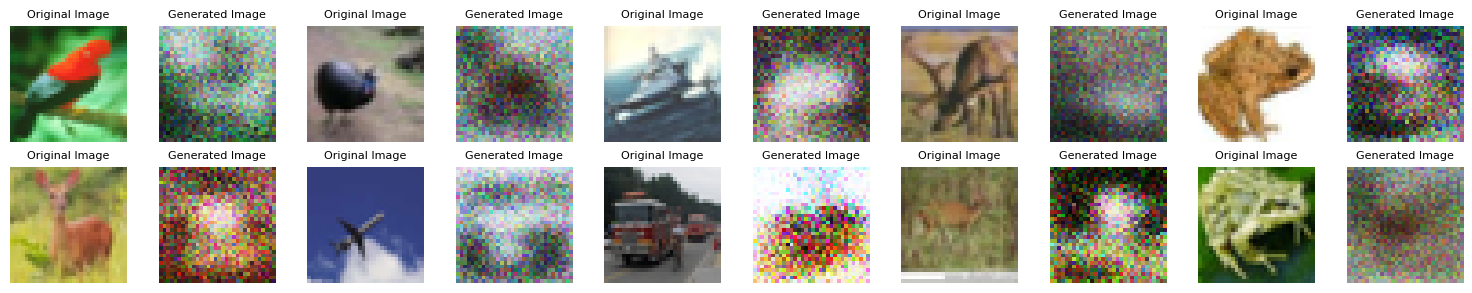

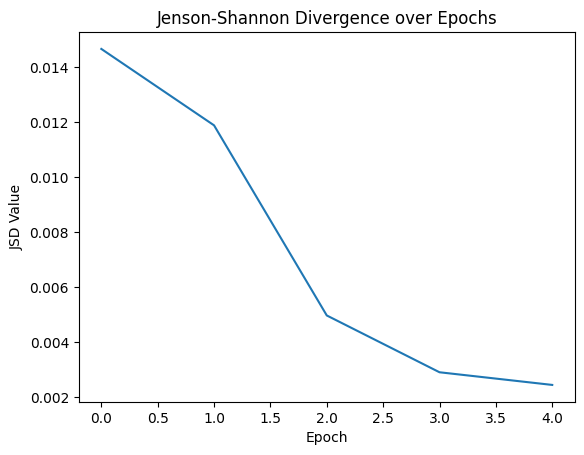

With latent_dim=100 and complexity=256


4/4 [==============================] - 0s 5ms/step
Epoch 1/5 [D loss: 0.4215737581253052] [G loss: 2.450099468231201] [JSD: [0.08218468]]
4/4 [==============================] - 0s 7ms/step
Epoch 2/5 [D loss: 0.3448152244091034] [G loss: 3.4053616523742676] [JSD: [0.15114726]]
4/4 [==============================] - 0s 8ms/step
Epoch 3/5 [D loss: 0.3697173595428467] [G loss: 4.911266326904297] [JSD: [0.17401075]]
4/4 [==============================] - 0s 5ms/step
Epoch 4/5 [D loss: 0.3240332007408142] [G loss: 3.5288543701171875] [JSD: [0.1379105]]
4/4 [==============================] - 0s 7ms/step
Epoch 5/5 [D loss: 0.4852047562599182] [G loss: 1.6450327634811401] [JSD: [0.07501492]]
1/1 [==============================] - 0s 123ms/step


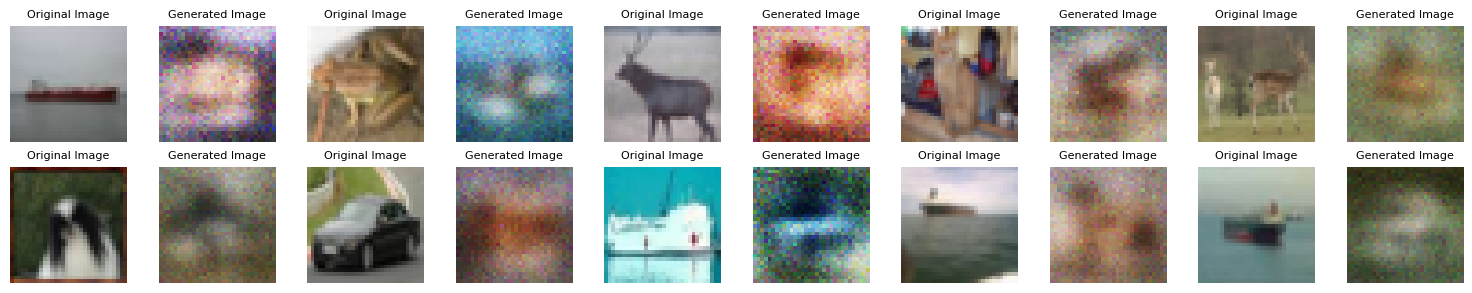

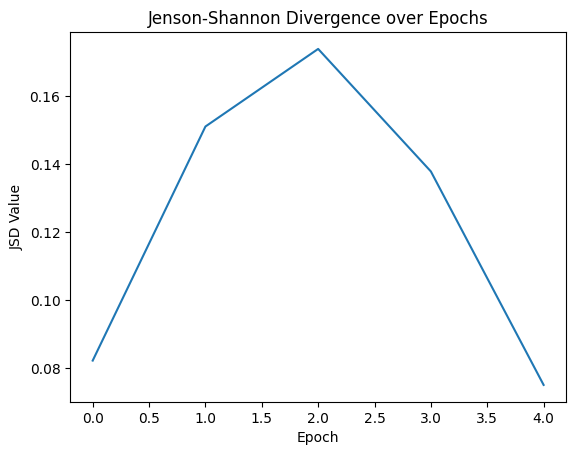

With latent_dim=100 and complexity=32


4/4 [==============================] - 0s 3ms/step
Epoch 1/5 [D loss: 0.6102834343910217] [G loss: 1.1292526721954346] [JSD: [0.0230238]]
4/4 [==============================] - 0s 4ms/step
Epoch 2/5 [D loss: 0.6875978708267212] [G loss: 0.8764255046844482] [JSD: [0.01106056]]
4/4 [==============================] - 0s 3ms/step
Epoch 3/5 [D loss: 0.691065788269043] [G loss: 0.9428137540817261] [JSD: [0.01000826]]
4/4 [==============================] - 0s 4ms/step
Epoch 4/5 [D loss: 0.6797277331352234] [G loss: 0.8872553706169128] [JSD: [0.00828669]]
4/4 [==============================] - 0s 3ms/step
Epoch 5/5 [D loss: 0.679902195930481] [G loss: 0.9855798482894897] [JSD: [0.01188032]]
1/1 [==============================] - 0s 138ms/step


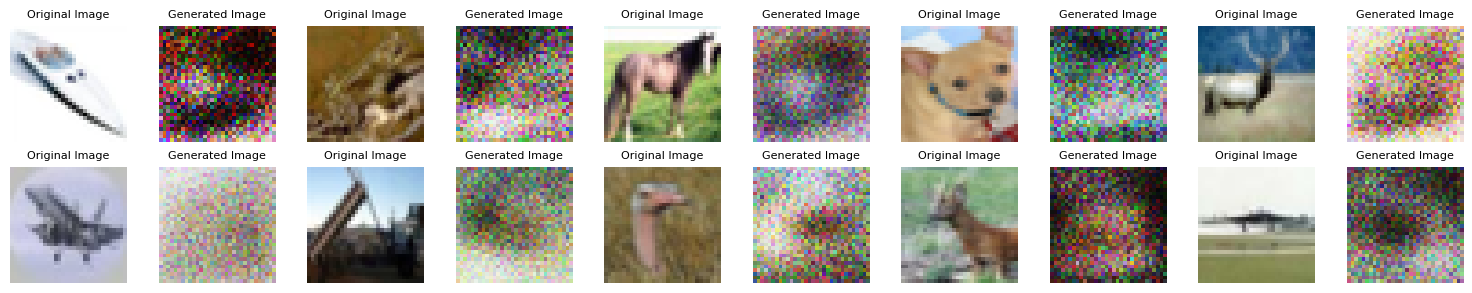

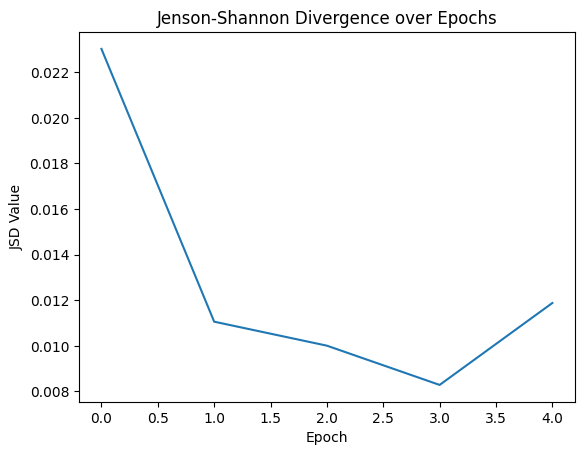

With latent_dim=100 and complexity=64


4/4 [==============================] - 0s 4ms/step
Epoch 1/5 [D loss: 0.7027108669281006] [G loss: 1.030242919921875] [JSD: [0.01362706]]
4/4 [==============================] - 0s 3ms/step
Epoch 2/5 [D loss: 0.7108123302459717] [G loss: 0.9625993967056274] [JSD: [0.0120697]]
4/4 [==============================] - 0s 4ms/step
Epoch 3/5 [D loss: 0.6784465312957764] [G loss: 0.902900218963623] [JSD: [0.01300604]]
4/4 [==============================] - 0s 3ms/step
Epoch 4/5 [D loss: 0.6933693289756775] [G loss: 0.8831455707550049] [JSD: [0.0096754]]
4/4 [==============================] - 0s 4ms/step
Epoch 5/5 [D loss: 0.6755962371826172] [G loss: 0.8711144924163818] [JSD: [0.01053447]]
1/1 [==============================] - 0s 134ms/step


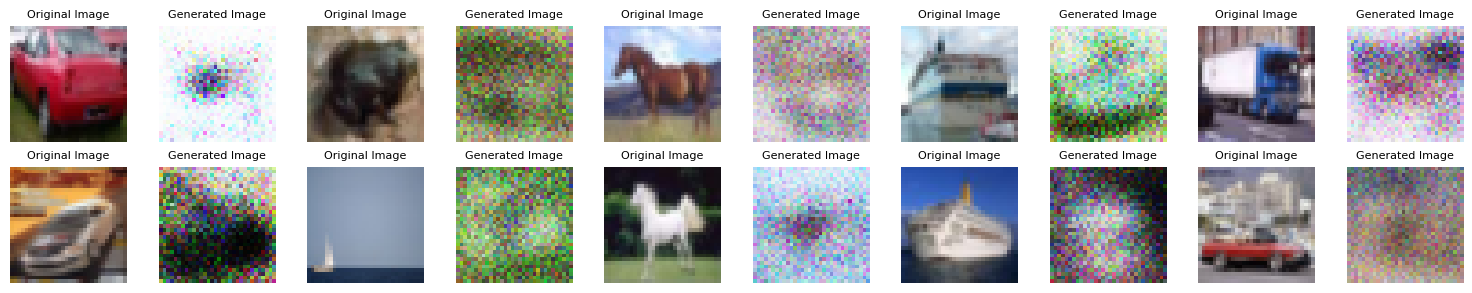

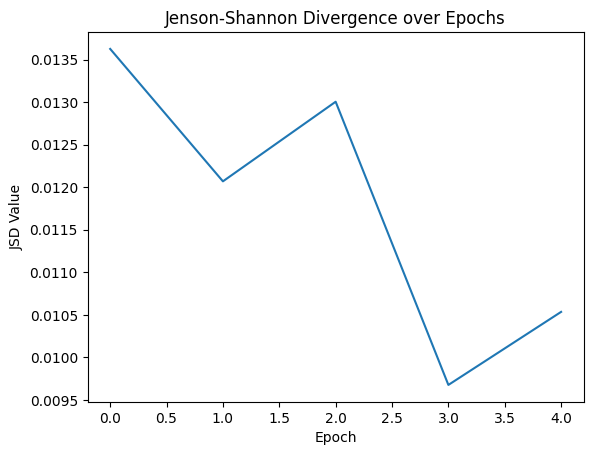

With latent_dim=100 and complexity=128


4/4 [==============================] - 0s 4ms/step
Epoch 1/5 [D loss: 0.6620147824287415] [G loss: 1.2266933917999268] [JSD: [0.01282876]]
4/4 [==============================] - 0s 5ms/step
Epoch 2/5 [D loss: 0.6937955617904663] [G loss: 0.946317732334137] [JSD: [0.00685578]]
4/4 [==============================] - 0s 5ms/step
Epoch 3/5 [D loss: 0.6838250160217285] [G loss: 0.9087712168693542] [JSD: [0.00718591]]
4/4 [==============================] - 0s 4ms/step
Epoch 4/5 [D loss: 0.6771019101142883] [G loss: 0.8966823816299438] [JSD: [0.00831769]]
4/4 [==============================] - 0s 5ms/step
Epoch 5/5 [D loss: 0.6747963428497314] [G loss: 0.8385969400405884] [JSD: [0.00301696]]
1/1 [==============================] - 0s 133ms/step


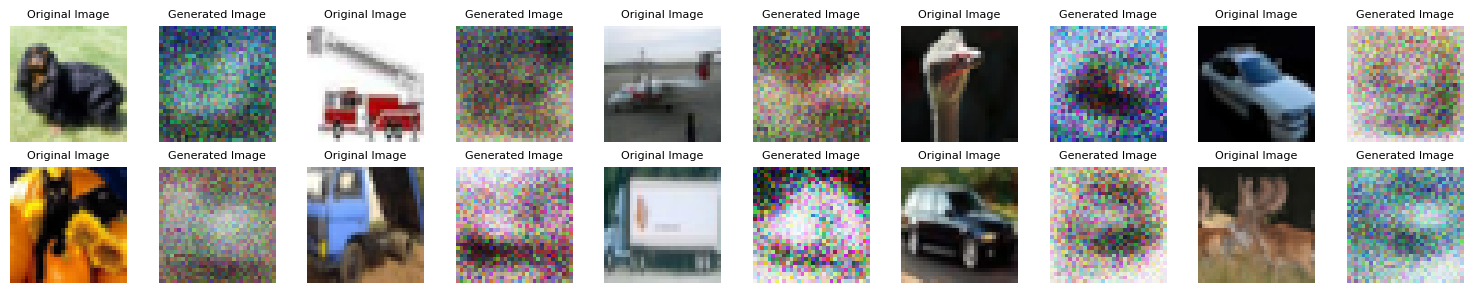

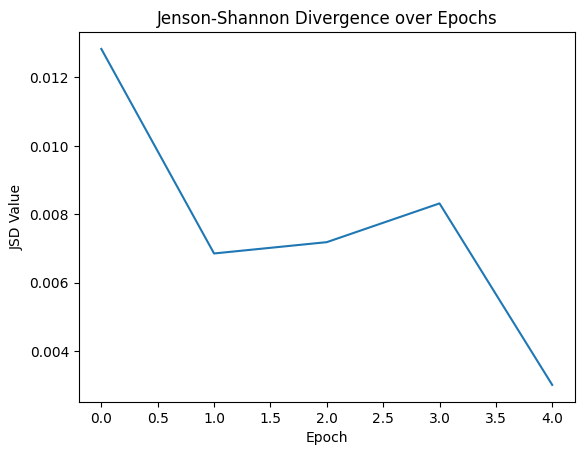

With latent_dim=100 and complexity=256


4/4 [==============================] - 0s 6ms/step
Epoch 1/5 [D loss: 0.48063379526138306] [G loss: 3.4459125995635986] [JSD: [0.18809493]]
4/4 [==============================] - 0s 6ms/step
Epoch 2/5 [D loss: 0.3471376895904541] [G loss: 3.3717637062072754] [JSD: [0.14600718]]
4/4 [==============================] - 0s 7ms/step
Epoch 3/5 [D loss: 0.2655775249004364] [G loss: 4.139260292053223] [JSD: [0.12462837]]
4/4 [==============================] - 0s 6ms/step
Epoch 4/5 [D loss: 0.44983577728271484] [G loss: 1.8783659934997559] [JSD: [0.07766318]]
4/4 [==============================] - 0s 5ms/step
Epoch 5/5 [D loss: 0.37623000144958496] [G loss: 2.064638614654541] [JSD: [0.07360007]]
1/1 [==============================] - 0s 133ms/step


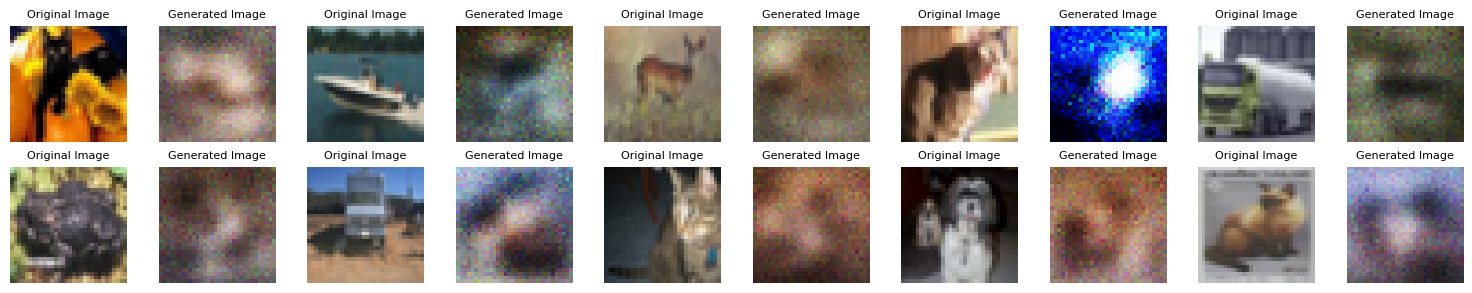

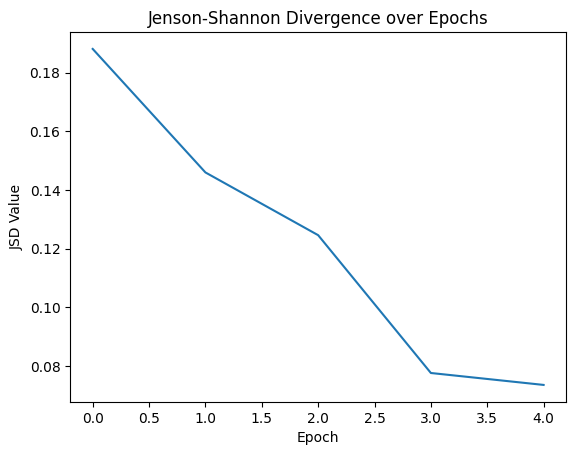

In [10]:
latent_dim = 100
complexity_values = [32, 64, 128, 256]

# Set the image shape for CIFAR-10
img_shape = (32, 32, 3)

for complexity in complexity_values:
    print(f"With latent_dim={latent_dim} and complexity={complexity}")
    generator = build_generator(latent_dim, img_shape,complexity)
    discriminator = build_discriminator(img_shape,complexity)
    gan = build_gan(generator, discriminator)
    generator, jsd_values = train_gan(generator, discriminator, gan, epochs, batch_size)
    plot_original_and_generated_images(generator, epochs, latent_dim)
    plot_jsd_over_epochs(jsd_values)